In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np
import torch

torch.manual_seed(42)
np.random.seed(42)

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, noise_dim, label_dim):
        super().__init__()
#         self.input = nn.Linear(noise_dim + label_dim, hidden_dim)
        self.input = nn.Linear(noise_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, input_dim)

#     def forward(self, noise, label):
    def forward(self, noise):
#         out = F.relu(self.input(torch.cat((noise, label), -1)))
        out = F.leaky_relu(self.input(noise))
        out = F.leaky_relu(self.hidden(out), negative_slope=0.005)
        out = self.dropout(out)
        
#         out = F.leaky_relu(self.hidden2(out), negative_slope=0.005)
#         out = self.dropout2(out)
        
        out = self.hidden3(out)
        out = self.output(out)

        return out


class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim):
        super().__init__()
#         self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
    
#     def forward(self, x, label):
    def forward(self, x):
#         out = F.relu(self.input(torch.cat((x, label), -1)))
        out = F.leaky_relu(self.input(x), negative_slope=0.005)
#         out = self.batch_norm(F.relu(self.hidden(out)))
        out = F.leaky_relu(self.hidden(out), negative_slope=0.005)
        out = self.dropout(out)
        
        out = F.leaky_relu(self.hidden2(out), negative_slope=0.005)
        out = self.dropout2(out)
        
        out = self.hidden3(out)
        out = self.output(out)
        
        return out

In [2]:
# Load dataset 
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
df["Price"] = bos.target

# # Standardize
data = df[df.columns[:-1]]
# data = data.apply(
#     lambda x: (x - x.mean()) / x.std()
# )

data['Price'] = df.Price

print(df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  Price  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


## Test

## 1-NN

In [3]:
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
# Define the models
# Dataset to tensor 
# 
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64).view(-1, 1)

X_TRAIN, X_test, Y_TRAIN, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
Y_TRAIN = Y_TRAIN.view(-1, 1)
Y_test = Y_test.view(-1, 1)

# Standardize data 
scaler = preprocessing.StandardScaler().fit(X_TRAIN)
X_TRAIN = torch.tensor(scaler.transform(X_TRAIN)).type(torch.float64)
    # Should not t
    # Want to use the same standard deviation and mean as the train dataset because our model thinks
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

### Standardization
X = X_train + X_test
(X - mean(X)) / std(X) -- This is bad because we are introducing information about "future" data into our training set 

X_train = (X_train - mean(X_train)) / std(X_train) 
X_test = (X_test - mean(X_test)) / std(X_test)
-- Think of test set as a data that we are making prediction for (as if we didn't have y values).
You can see why we would need to apply the normalization scales of train data to test data. 
You don't get an entire set of input data all at once, same model can be used many times on different input values. Then we don't really know what the mean and standard deviation of all inputs are. 
We assume that the data that we get are from the same scales as the test data and use its scale values.
Always assume that the model does not know the distribution (or in this case scale) of the data that it needs to make pre

Correct way 
X_train = (X_train - mean(X_train)) / std(X_train)
X_test = (X_test - mean(X_train)) / std(X_train)

In [4]:
# Define hyperparameters 
N_EPOCHS = 40
BATCH_SIZE = 128
lr = 0.001
INPUT_DIM = X.shape[1]
LABEL_DIM = Y.shape[1]
NOISE_DIM = 5
HIDDEN_DIM = 5

In [5]:
# Define the models
gen = Generator(INPUT_DIM, HIDDEN_DIM, NOISE_DIM, LABEL_DIM).type(torch.float64)
dis = Discriminator(INPUT_DIM, LABEL_DIM, HIDDEN_DIM).type(torch.float64)

prior = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

In [6]:
# Define optimizers 
optG = torch.optim.Adam(gen.parameters(), lr=lr, weight_decay=1e-4)
optD = torch.optim.Adam(dis.parameters(), lr=lr, weight_decay=1e-4)

logsigmoid = torch.nn.LogSigmoid()

In [7]:
""" Cross Validation """
# Leave one out 
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
print(loo.get_n_splits(X_TRAIN))
print(len(X_TRAIN))


# K fold
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)

354
354


In [8]:
train_accuracy = []

training_set = []


for ep in range(N_EPOCHS):
    train_accuracy.append(0)
    num_batches = 0 
    for train_index, test_train_index in loo.split(X_TRAIN):
#     for train_index, test_train_index in kf.split(X_TRAIN):
        dis.train()
        gen.train()
        X_train, X_test_train = X_TRAIN[train_index], X_TRAIN[test_train_index]
#         Y_train, Y_test_train = Y_TRAIN[train_index], Y_TRAIN[test_train_index]
        
        N = len(X_train)
        
        """ Train Discriminator """
        # zero grad 
        optD.zero_grad()
        
        # Forward pass 
        # 1. Discriminator 
#         outD = dis(X_train, Y_train)
        outD = dis(X_train)
        
        # 2. Generator-Discriminator
        noise_dis = prior.sample((N, NOISE_DIM)).type(torch.float64)
#         outG_dis = gen(noise_dis, Y_train)
        outG_dis = gen(noise_dis)
#         outDG_dis = dis(outG_dis, Y_train)
        outDG_dis = dis(outG_dis)
        
        # Loss
        lossD = -torch.mean(logsigmoid(outD)*0.8 + logsigmoid(1 - outDG_dis)*0.9)
        
        # Backward
        lossD.backward()
        
        # Update parameters 
        optD.step()
                
        """ Train Generator """
        # zero grad 
        optG.zero_grad()
        
        # Forward pass 
        noise_gen = prior.sample((N, NOISE_DIM)).type(torch.float64)
#         outG_gen = gen(noise_gen, Y_train)
        outG_gen = gen(noise_gen)
#         outDG_gen = dis(outG_gen, Y_train)
        outDG_gen = dis(outG_gen)
        
        # Loss 
        lossG = -torch.mean(logsigmoid(outDG_gen))
        
        # Backward 
        lossG.backward()
        
        # Update parameters 
        optG.step()
        
        """ Train Accuracy (Leave one out) """
        dis.eval()
        gen.eval()
        # Forward pass
        # 1. Discriminator
#         outD = dis(X_test_train, Y_test_train)
        outD = dis(X_test_train)
        outD = torch.nn.Sigmoid()(outD[0,0])
#         outD = torch.nn.Sigmoid()(outD)
        outD_acc = int((outD > 0.5) == 1)
#         outD_acc = torch.sum((outD > 0.5) == 1)
        
        train_accuracy[-1] += outD_acc 
        num_batches += 1
#         num_batches += X_test_train.shape[0]
        

        # 2. Generator-Discriminator
        noise = prior.sample((X_test_train.shape[0], NOISE_DIM)).type(torch.float64)
#         outG = gen(noise, Y_test_train)
        outG = gen(noise)
#         outDG = dis(outG, Y_test_train)
        outDG = dis(outG)
        outDG = torch.nn.Sigmoid()(outDG[0,0])
#         outDG = torch.nn.Sigmoid()(outDG)
        outDG_accuracy = int((outDG > 0.5) == 0)
#         outDG_accuracy = torch.sum((outDG > 0.5) == 0)
        
        train_accuracy[-1] += outDG_accuracy
        num_batches += 1     
#         num_batches += X_test_train.shape[0]
    
    train_accuracy[-1] /= num_batches
#     train_accuracy[-1] = train_accuracy[-1].item() / num_batches

    print("Epoch [%d / %d] average reconstruction error: %f" % (ep+1, N_EPOCHS, train_accuracy[-1]))
    
    # https://arxiv.org/pdf/1802.03446.pdf
    # https://arxiv.org/pdf/1610.06545.pdf

Epoch [1 / 40] average reconstruction error: 0.500000
Epoch [2 / 40] average reconstruction error: 0.587571
Epoch [3 / 40] average reconstruction error: 0.675141
Epoch [4 / 40] average reconstruction error: 0.872881
Epoch [5 / 40] average reconstruction error: 0.872881
Epoch [6 / 40] average reconstruction error: 0.872881
Epoch [7 / 40] average reconstruction error: 0.872881
Epoch [8 / 40] average reconstruction error: 0.872881
Epoch [9 / 40] average reconstruction error: 0.874294
Epoch [10 / 40] average reconstruction error: 0.872881
Epoch [11 / 40] average reconstruction error: 0.529661
Epoch [12 / 40] average reconstruction error: 0.504237
Epoch [13 / 40] average reconstruction error: 0.494350
Epoch [14 / 40] average reconstruction error: 0.500000
Epoch [15 / 40] average reconstruction error: 0.500000
Epoch [16 / 40] average reconstruction error: 0.500000
Epoch [17 / 40] average reconstruction error: 0.500000
Epoch [18 / 40] average reconstruction error: 0.500000
Epoch [19 / 40] ave

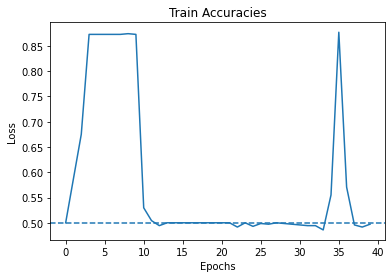

In [9]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_accuracy)
plt.axhline(0.5, linestyle='--')
plt.title("Train Accuracies")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [10]:
# Test Test 
# outD = dis(X_test, Y_test)
outD = dis(X_test)

noise = prior.sample((len(X_test), NOISE_DIM)).type(torch.float64)
# outG = gen(noise, Y_test)
outG = gen(noise)
# outDG = dis(outG, Y_test)
outDG = dis(outG)

output = torch.cat((outD, outDG))
label_real = torch.ones(outD.shape)
label_fake = torch.zeros(outDG.shape)
labels = torch.cat((label_real, label_fake))

accuracy = torch.mean(((output > 0.5) == labels).type(torch.float64)).item()

print("Final test accuracy on held out data: ", accuracy)

Final test accuracy on held out data:  0.8223684210526315


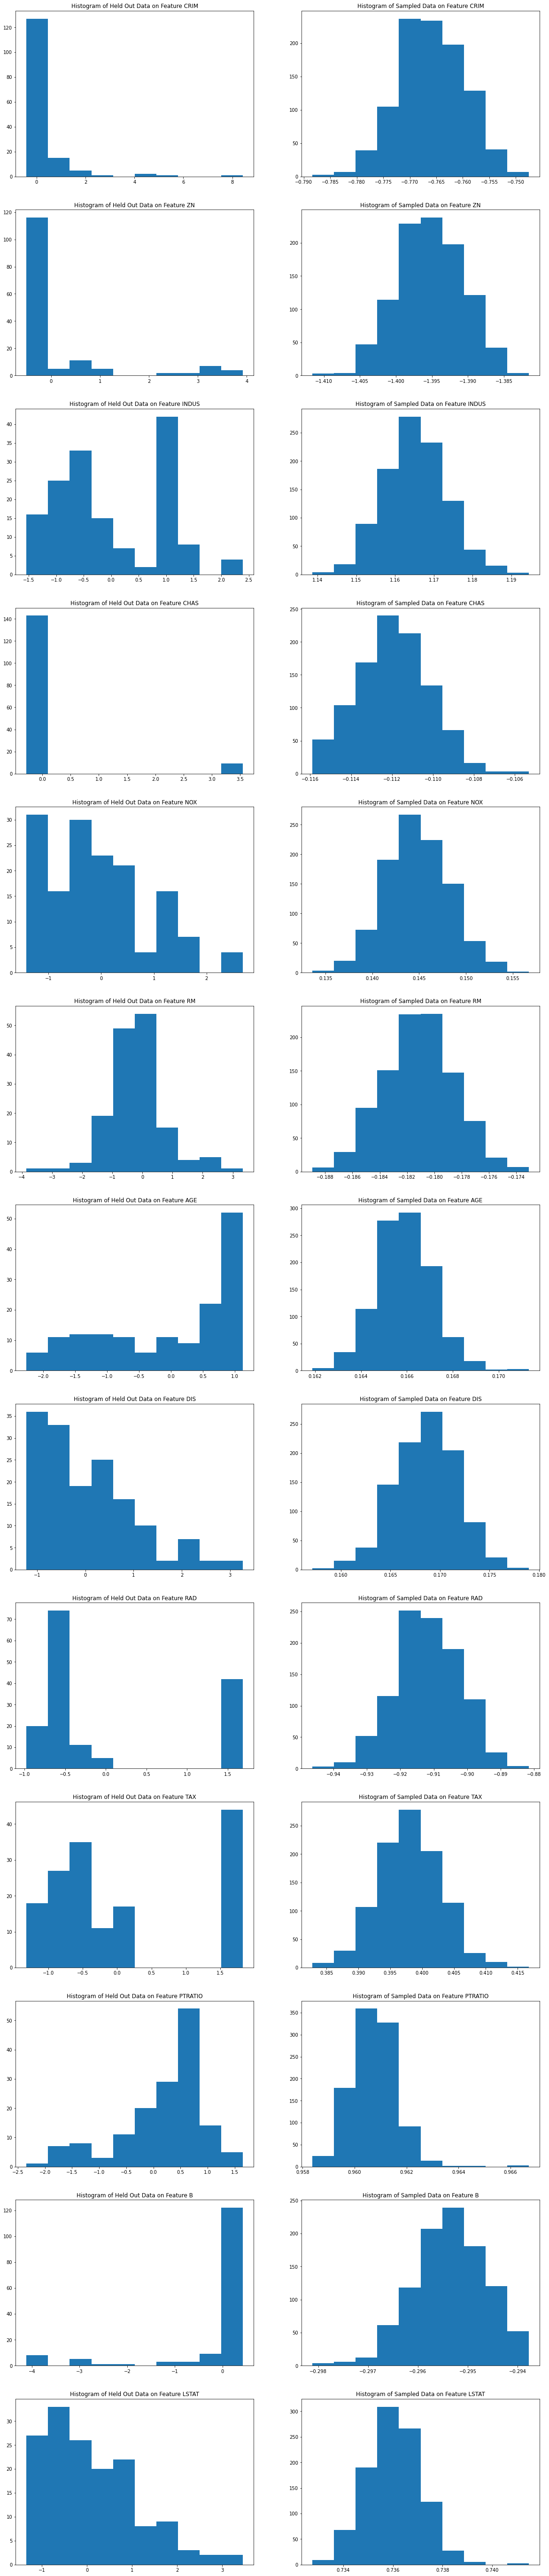

In [11]:
# for i in range(x_samples.shape[1]):
noise = prior.sample((1000, NOISE_DIM)).type(torch.float64)
outG = gen(noise)

x_out = outG.detach().numpy()
x_test = X_test.detach().numpy()
figs, axs = plt.subplots(x_out.shape[1], 2, figsize=(20, 100))
# # print(X_test[:,0].shape)
# # print(X_test[:,0].min())
# # print(X_test[:,0].max())
# # print(x_samples[:,0].min())
# # print(x_samples[:,0].max())
# def get_axis_limits(ax, scale=.9):
#     return ax.get_xlim()[1]*scale, ax.get_ylim()[1]*scale
for i in range(x_out.shape[1]):
    x_test_mean = x_test[:,i].mean()
    axs[i, 0].hist(x_test[:,i])
    axs[i, 0].set_title("Histogram of Held Out Data on Feature " + bos.feature_names[i])
#     axs[i, 0].annotate("Mean : {}\n Std: {}".format(np.round_(x_out[:,i].mean(), 3), np.round_(x_out[:,i].std(), 3)), xy=get_axis_limits(axs[i, 0]), size=15)
    axs[i, 1].hist(x_out[:,i])
#     axs[i, 1].annotate("Mean : {}\n Std: {}".format(np.round_(x_test[:,i].mean(), 3), np.round_(x_test[:,i].std(), 3)), xy=get_axis_limits(axs[i, 1]), size=15)
    axs[i, 1].set_title("Histogram of Sampled Data on Feature " + bos.feature_names[i])

plt.show()

In [12]:
x_out.mean(0)

array([-0.76589134, -1.39516346,  1.16533686, -0.11192388,  0.1448526 ,
       -0.18113384,  0.16589218,  0.16860363, -0.91184585,  0.39808769,
        0.96075326, -0.29535825,  0.73604227])

In [13]:
x_test.mean(0)

array([ 0.05758123, -0.00594503,  0.00179102, -0.05457096, -0.07319324,
       -0.19021743, -0.02709023,  0.04573705,  0.04304216,  0.02391869,
        0.26229687, -0.11611849,  0.10870962])

In [14]:
x_out.std(0)

array([0.0062458 , 0.00457489, 0.00813159, 0.00174568, 0.003421  ,
       0.00257609, 0.00122022, 0.00313775, 0.00971762, 0.00488531,
       0.00088562, 0.00071637, 0.00108983])

In [15]:
x_test.std(0)

array([1.11058185, 1.10298352, 0.96335937, 0.90474325, 0.9732048 ,
       0.90859733, 1.05820349, 0.96849369, 1.02646713, 1.04093606,
       0.83007593, 1.15621229, 1.01067781])

### Mean and std correlations

Text(0, 0.5, 'Mean of Generated Distribution')

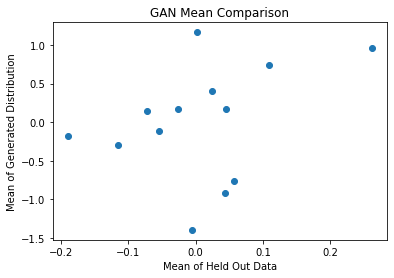

In [16]:
plt.scatter(x_test.mean(0), x_out.mean(0))
plt.title("GAN Mean Comparison")
plt.xlabel("Mean of Held Out Data")
plt.ylabel("Mean of Generated Distribution")

Text(0, 0.5, 'Standard Deviation of Generated Distribution')

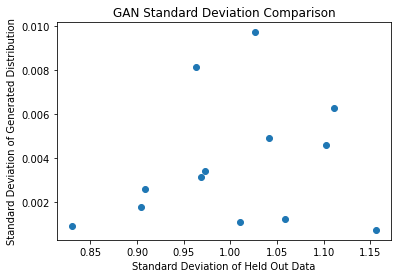

In [17]:
plt.scatter(x_test.std(0), x_out.std(0))
plt.title("GAN Standard Deviation Comparison")
plt.xlabel("Standard Deviation of Held Out Data")
plt.ylabel("Standard Deviation of Generated Distribution")

### Correlation Coefficients

In [18]:
np.corrcoef(x_test, rowvar=False)[0]

array([ 1.        , -0.1910687 ,  0.42486438, -0.08718963,  0.46821577,
       -0.23795259,  0.38613771, -0.40293044,  0.63190985,  0.58463217,
        0.27942462, -0.52906495,  0.55059428])

In [19]:
np.corrcoef(x_out, rowvar=False)[0]

array([ 1.        ,  0.98950767,  0.73626869, -0.48699273,  0.94884109,
       -0.86095592,  0.93910841, -0.94879803,  0.99690958,  0.91595689,
       -0.84151595,  0.37879965, -0.59746392])